In [299]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import ast
import plotly.figure_factory as ff

from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import jaccard_score
from sklearn.metrics import adjusted_mutual_info_score as ami

import re
import xarray as xr
import random

# Table of Content
##      Summary
## Quantitative Data Clustering
* Size Clustering
## Qualitative Data Clustering
* Depth Clustering
* Diet Clustering
## Cluster Analysis
* Rand Index
* Jaccard Index
* Mutual Information Index
## MCMC Algorithm Application
* Labels optimization algorithm

# Summary

## Some Context
At the start of the project I was asked to find a good clustering approach that could explain why sharks have been grouped in that way in a published model.  
I did not have access yet to the original data they used, so I used independent data found in literature for the same spatial zone.

Later this plan has been called off because of a change of direction of the whole project.

## Goal
The goal is to obtain clusters for sharks according to 3 different variables
* Size
* Depth in which sharks are found
* Diet items (composition is not available)

## Data Imports

In [300]:
size_df = pd.read_csv('./calc_database/size_database.csv', usecols=['Species', 'W inf (kg)', 'Taxonomic Unit'])
depth_df = pd.read_csv('./calc_database/depth_database.csv', usecols=['Species', 'Boolean Zones (reversed)', 'Fishbase Zones (reversed)'])
depth_df['Fishbase Zones (reversed)'] =[ast.literal_eval(i) for i in depth_df['Fishbase Zones (reversed)']]
depth_df['Boolean Zones (reversed)'] =[ast.literal_eval(i) for i in depth_df['Boolean Zones (reversed)']]
diet_df = pd.read_csv('./calc_database/diet_database.csv')

cont_scale=[
    [0, 'rgb(234, 172, 139)'],
    [0.5, 'rgb(181, 101, 118)'],
    [1, 'rgb(53, 80, 112)']]

cont_scale_boolean=[
    [0, 'rgb(255,255,255)'],
    [0.01, 'rgb(234, 172, 139)'],
    [0.5, 'rgb(181, 101, 118)'],
    [1, 'rgb(53, 80, 112)']]

discrete_scale=[
    'rgb(231, 111, 81)',
    'rgb(244, 162, 97)',
    'rgb(233, 196, 106)',
    'rgb(42, 157, 143)',
    'rgb(38, 70, 83)',
]

# Quantitative data Clustering <a class="anchor" id='quantitativeclus'></a>
In this case an agglomerative hierarchical clustering algorythm has been applied using Ward's minimum variance method.

[Scipy Linkage Doc.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)  
[Scipy Dendrogram Doc.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html)  
[Plotly FF Dendrogram Doc.](https://plotly.github.io/plotly.py-docs/generated/plotly.figure_factory.create_dendrogram.html)

#### Ward Algorithm
Ward's minimum variance criterion minimizes the total within-cluster variance. To implement this method, at each step find the pair of clusters that leads to **minimum increase in total within-cluster variance** after merging. This increase is a weighted squared distance between cluster centers. At the initial step, all clusters are singletons.  
To apply a recursive algorithm under this objective function, the initial distance between individual objects must be (proportional to) squared Euclidean distance.  
The initial cluster distances in Ward's minimum variance method are therefore defined to be the squared Euclidean distance between points:
$$ d_{ij}=d(\{X_i\}, \{X_j\}) = { \|X_i - X_j\|^2} $$
The algorithm implemented in this function calculates the distance as  
$$ d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2+ \frac{|v|+|t|}{T}d(v,t)^2- \frac{|v|}{T}d(s,t)^2} $$  
Where $u$ is the newly joined cluster consisting of clusters $s$ and $t$;  
$v$ is an unused cluster in the forest, $T=|v|+|s|+|t|$, and $|*|$ is the cardinality of its argument (number of elements in the cluster).  
This is also known as the **Lance-Williams** recursive algorithm.

## Size Clustering <a class="anchor" id="size"></a>
#### Size Cluster correction
3 species have no size data in literature. In order to be able to assign them to a cluster, unpublished data is used.

|Species|Length [mm] (unpublished)| $W_{\infty}$ [Kg] (calculated)|Source|
|---|---|---|---|
|*Leucoraja fullonica*| 1100 | 16| [Shark Reference](https://shark-references.com/species/view/Leucoraja-fullonica)|
|*Leucoraja melitensis*|500 | 0.56 | [Shark Reference](https://shark-references.com/species/view/Leucoraja-melitensis)|
|*Myliobatis aquila*| ND | 21 | [Fishbase](https://www.fishbase.in/popdyn/KeyfactsSummary_2v2.php?ID=4330&GenusName=Myliobatis&SpeciesName=aquila&vStockCode=4518&fc=22)|

In [301]:
## manually setting ND data
size_df.loc[size_df['Species']=='Leucoraja fullonica', 'W inf (kg)'] = 16
size_df.loc[size_df['Species']=='Leucoraja melitensis', 'W inf (kg)'] = 0.56
size_df.loc[size_df['Species']=='Myliobatis aquila', 'W inf (kg)'] = 21

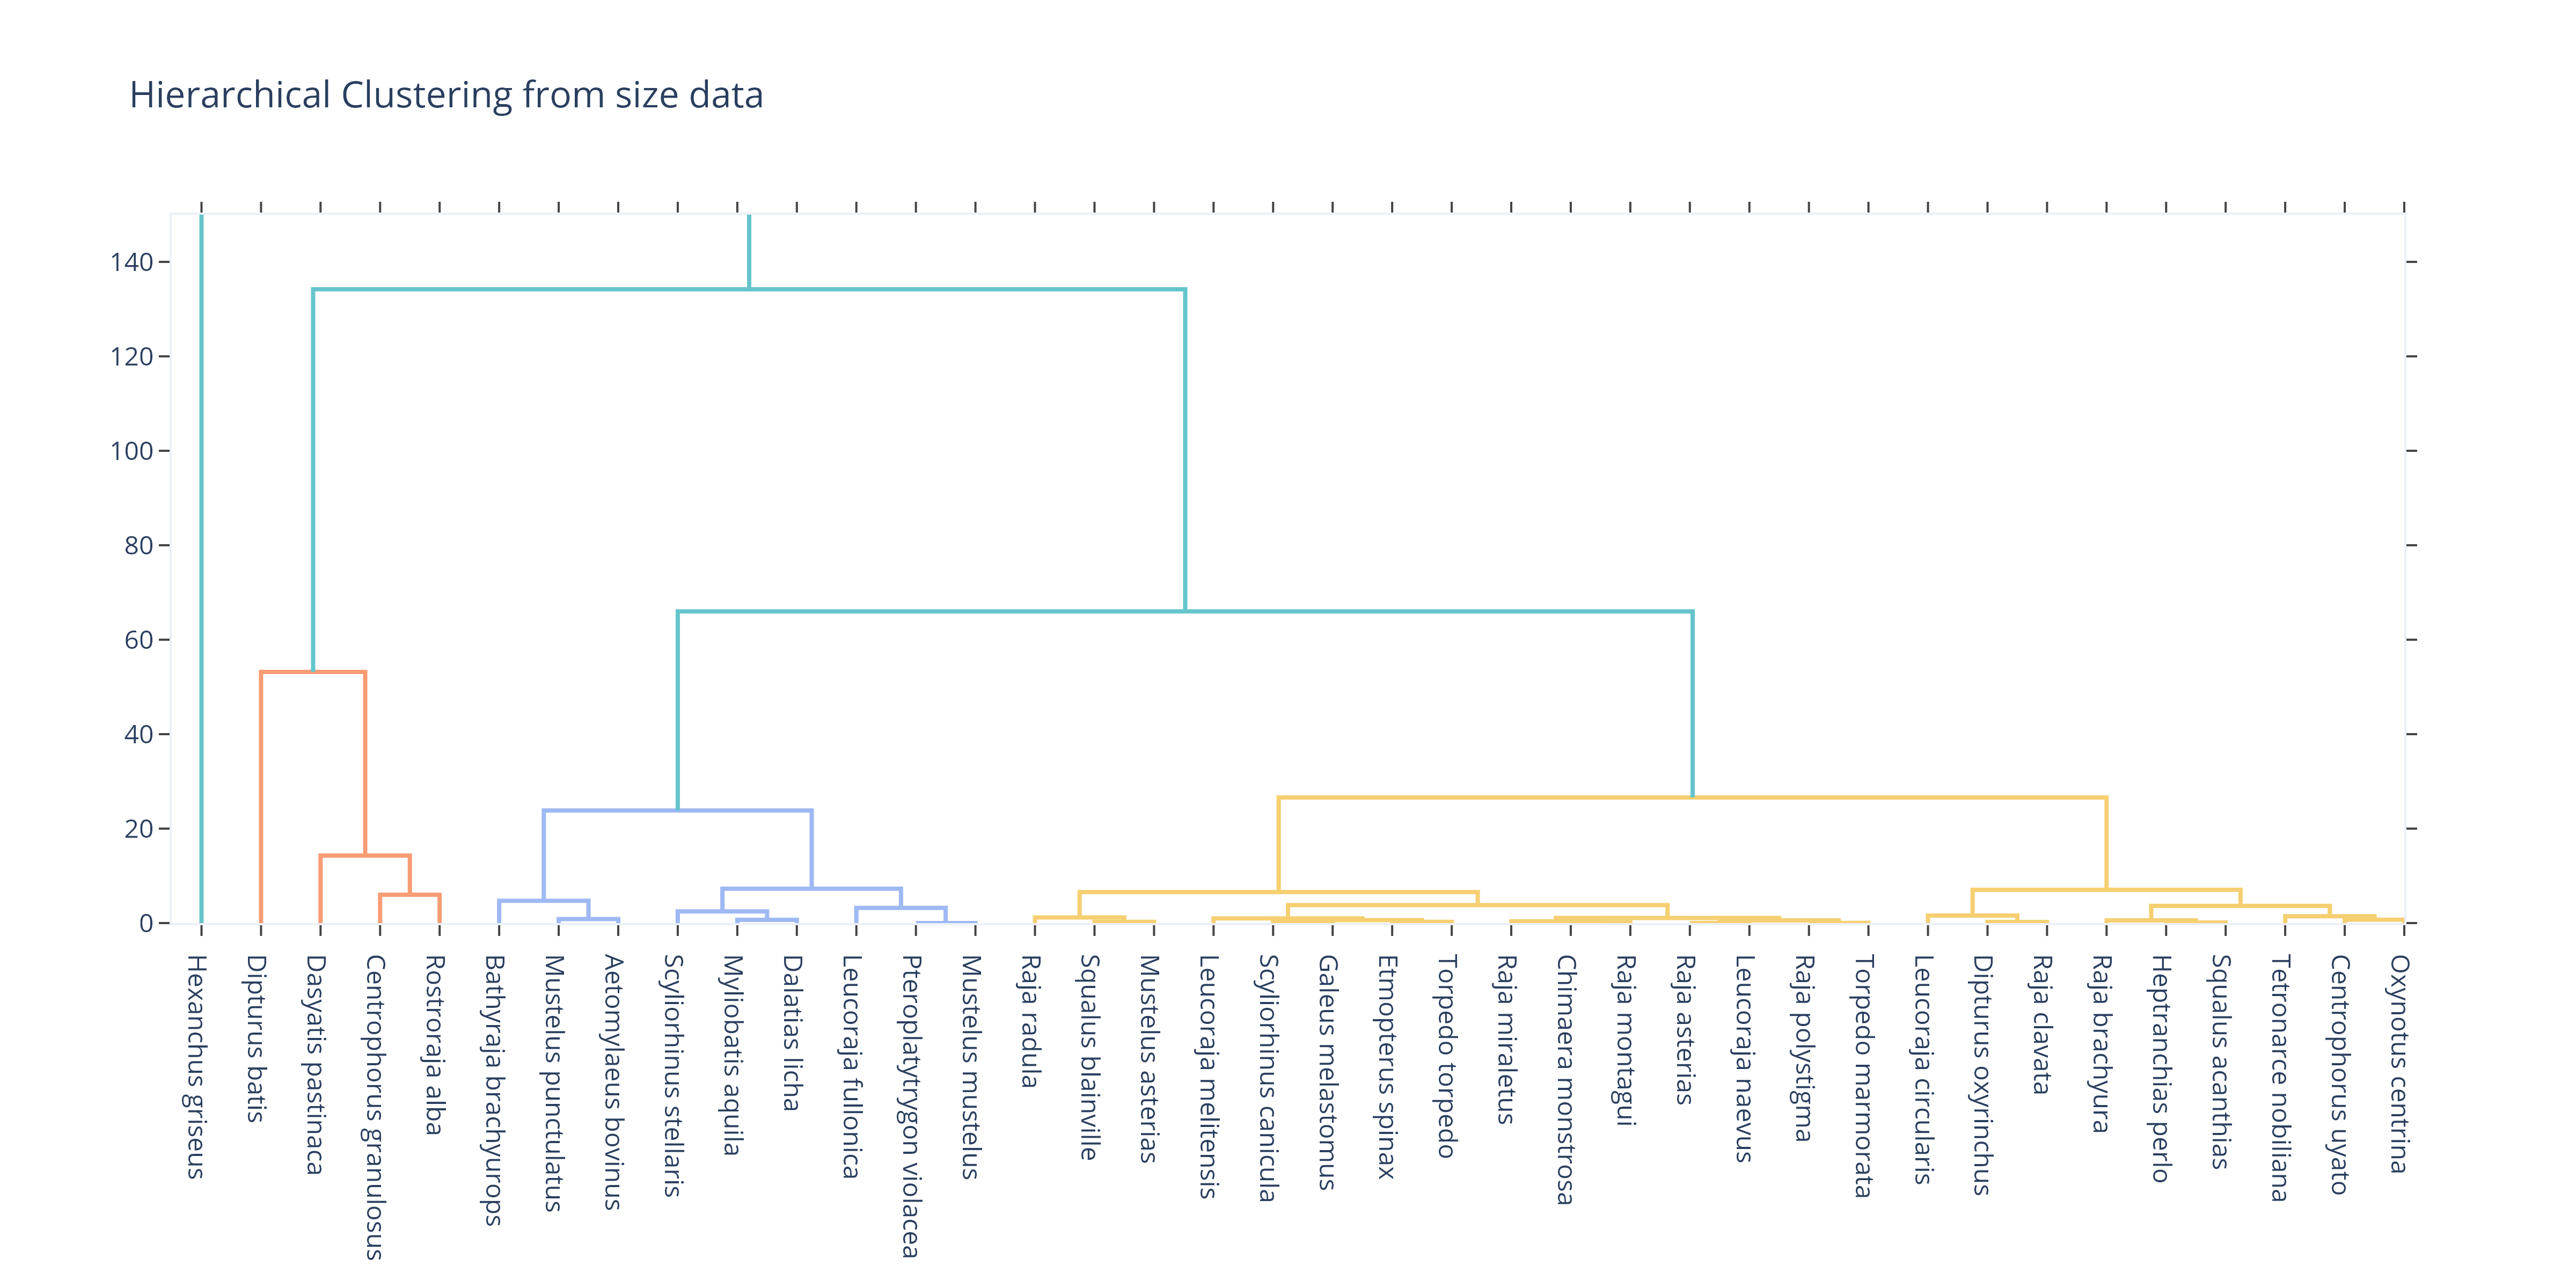

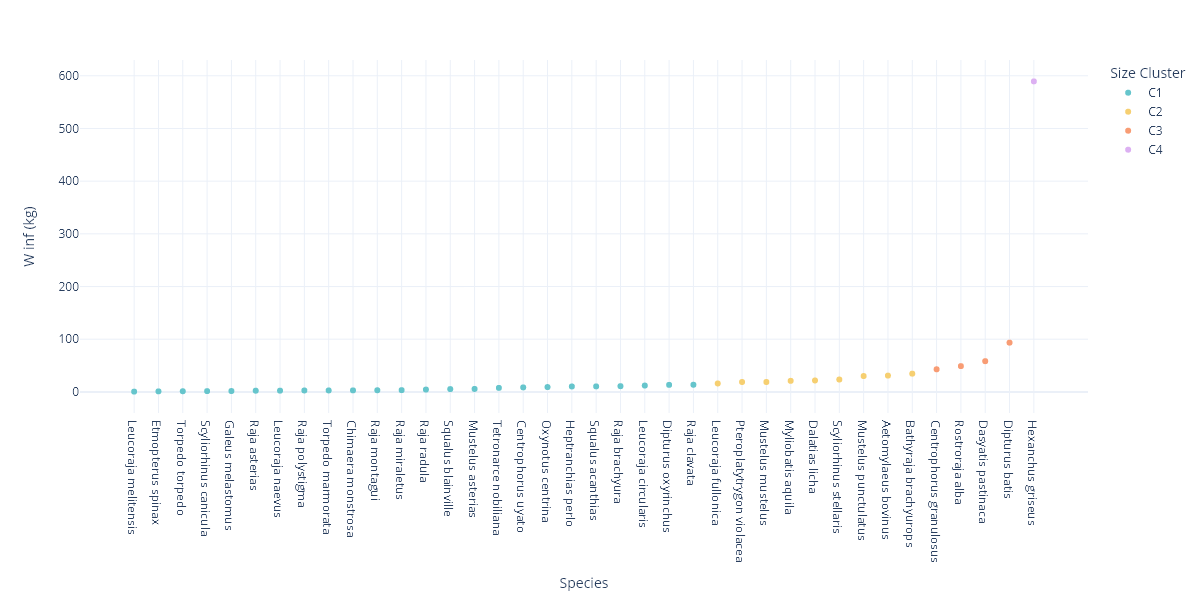

In [319]:
## Data preparation
size_series = size_df.set_index('Species')['W inf (kg)']
size_labels = size_series.index
size_list = [[np.round(i, 2)] for i in size_series]   ## dendrogram() need a list of list as input

#defining a function to clusterize and returns cluster names in the same order of input matrix
def get_cluster_names(input_data, method, threshold, raw_data=False, offset=0):
    ## input_data can be either a distance matrix or raw data in which case you need to flag raw_data=true
    if raw_data == False:
        link = linkage(distance.squareform(input_data)+offset, method=method)
    else:
        link = linkage(input_data, method=method)
    dendro = dendrogram(link, no_plot=True, color_threshold=threshold)
    indexes = [int(dendro['ivl'][i]) for i in range(len(dendro['ivl']))]
    clusterindex = dendro['leaves_color_list']
    clusterindex = pd.Series(clusterindex, index=indexes).sort_index()
    new_cluster_names = ['C{}'.format(i) for i in range(1, len(clusterindex.unique())+1)]
    clusterindex.replace(clusterindex.unique(), new_cluster_names, inplace=True)
    return clusterindex

# ## Hierarchical clustering
## Adding the Cluster info to the original dataset
size_threshold = 55
size_df['Size Cluster'] = get_cluster_names(size_list, 'ward', size_threshold, raw_data=True)
size_df.sort_values('W inf (kg)', ignore_index=True, inplace=True)

## plotting the dendrogram in plotly
size_list = np.array(size_list)
fig = ff.create_dendrogram(size_list, labels=size_labels,
    linkagefun=lambda x: linkage(size_list, 'ward', metric='euclidean'),
    color_threshold=size_threshold, colorscale=px.colors.qualitative.Pastel)
fig.update_layout(width=1200, height=600, title='Hierarchical Clustering from size data',
    template='plotly_white'
)
fig.update_yaxes(range=[0, 150])
fig.show('png', scale=4)
fig2 = px.scatter(size_df, color=size_df['Size Cluster'], x='Species', y='W inf (kg)', color_discrete_sequence=px.colors.qualitative.Pastel)
fig2.update_layout(template='plotly_white', width=1200, height=600)
fig2.show('png')


### 4 Clusters
Each clustering threshold is chosen in such a way that returns 4 clusters. That is because the original model contains 4 groups and initially these clusters were intented to be compared with the original groupings to clarify what type of clustering has been applied because it wasn't clearly explained in the paper.

# Qualitative data Clustering <a class="anchor" id="qualitativeclus"></a>
## Depth Clustering <a class="anchor" id='depth'></a>

### Data Correction
Depth from MEDITS surveys reported discontinuous presence of sharks in the 5 depth blocks defined. This data will be merged with literature data to fill the discontinuity.

### Similarity coefficient
To address the ecological double-zero problem an **Asymmetric similarity coefficient** has been chosen to define the distance between objects.

### *Coincidence Index*
### $ S_8 = \frac{2a}{2a+b+c}$

If data are expressed in a contingency table  


||Obj1|||
|-|-|-|-|
|**Obj2**||1|0|
||1|a|b|
||0|c|d|

where each parameter (a,b,c,d) is the number of times that the comparison between obj1 and obj2 had an outcome of that type 

- *a* = True x True
- *b* and *c* = True x False // False x True  

(if they both have a feature then it is a match and thus *a* increases while a mismatch is accounted for by *b* and *c*)

This index is calculated for each couple of species in the dataset.  
To obtain a **metric** distance matrix the following transformation must be conducted.  
#### $D = \sqrt{1-S_8}$

This index is monotonic with **Jaccard's Index** of similarity.

<sub> P. Legendre, L. Legendre, Numerical ecology 2ed. *eq. 7.11* </sub>

#### Average Linkage Algorithm
'Average Linkage' assigns $$ d(u,v) = \sum_{ij} \frac{d(u[i], v[j])}{(|u|*|v|)}$$ 
for all points $i$ and $j$ where $|u|$ and $|v|$ are the cardinalities of clusters $u$ and $v$, respectively. 
This is also called the **UPGMA**   
The distance between any two clusters is taken to be the average of all distances $d(u[i], v[j])$ between pairs of objects, that is the mean distance between elements of each cluster.  
The UPGMA algorithm produces rooted dendrograms and requires a constant-rate assumption - that is, it assumes an ultrametric tree in which the distances from the root to every branch tip are equal.


#### Depth Zones Correction

In [303]:
## Function to plot heatmaps with only 2 colors 
def plot_binary_heatmap(z_matrix, title='Title', **kwargs):
    my_colorscale=[
    [0, 'rgba(255,255,255,0)'],
    [0.5, 'rgba(255,255,255,0)'],
    [0.5, px.colors.qualitative.Pastel[0]],
    [1, px.colors.qualitative.Pastel[0]]]

    if 'xticks' not in kwargs.keys():
        xticks = list(range(len(z_matrix)))
    else:
        xticks = kwargs['xticks']
    if 'yticks' not in kwargs.keys():
        yticks = list(range(len(z_matrix)))
    else:
        yticks = kwargs['yticks']
    fig = go.Figure()

    fig.add_trace(go.Heatmap(
        z=z_matrix,
        transpose=True,
        x=xticks,
        y=yticks,
        colorscale=my_colorscale,
        showscale= False,
        colorbar=dict(
                tickvals=[0.25, 0.75],
                ticktext=['0', '1'],
            )
    ))
    fig.update_layout(
        title=title,
        template = 'plotly_white',
        width=1200, height=600
    )
    fig.show('png')

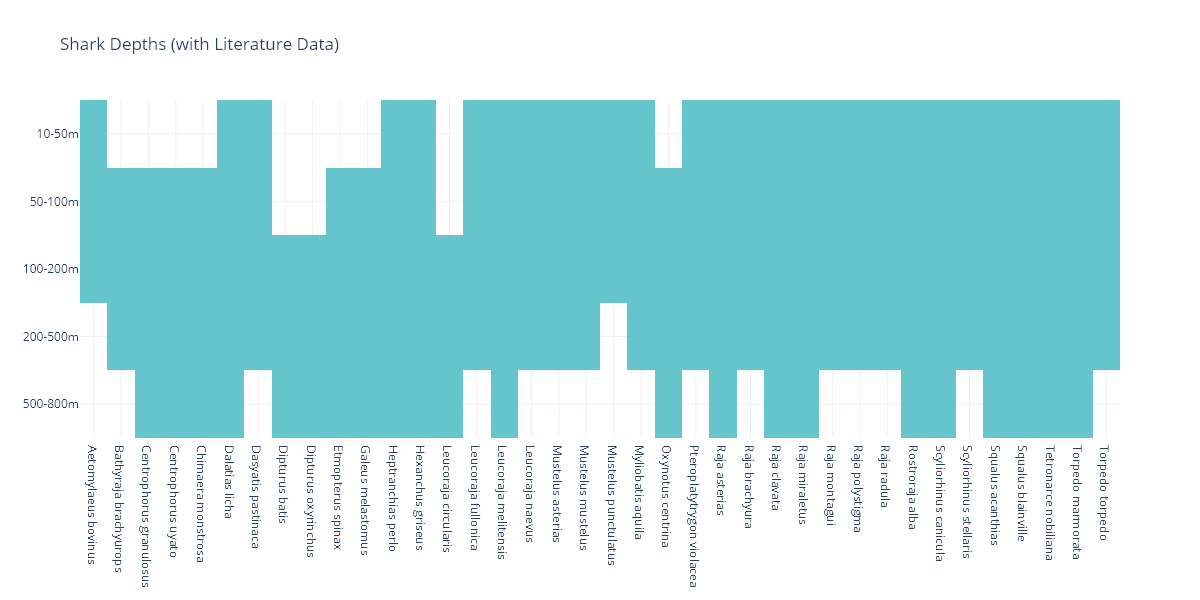

In [304]:
## Data preparation
# Replacing the discontinuous df with the continuous df
depth_df.sort_values('Species', inplace=True, ignore_index=True)
continuous_depth = pd.Series([[max(x) for x in zip(depth_df['Boolean Zones (reversed)'][i], depth_df['Fishbase Zones (reversed)'][i])] for i in range(len(depth_df['Fishbase Zones (reversed)']))])
depth_df['Fishbase Zones (reversed)'] = continuous_depth
depths = ['500-800m', '200-500m', '100-200m', '50-100m', '10-50m',]
depth_df = pd.DataFrame(depth_df.set_index('Species')['Fishbase Zones (reversed)'].tolist(), columns=depths, index=depth_df['Species'])

plot_binary_heatmap(depth_df, xticks=depth_df.index, yticks=depth_df.columns, title='Shark Depths (with Literature Data)')


### Coincidence Index Calculation

In [305]:
def calc_coincidence(v1, v2):
    s8 = 0          #name taken from Legendre book
    a = 0
    bc = 0
    for k in range(len(v1)):
        a += v1[k] & v2[k]
        bc += int(v1[k] != v2[k])
    try:
        s8 = (2*a)/(2*a+bc)
    except ZeroDivisionError:
        s8 = np.nan
    return s8

def calc_coincidence_matrix(df_series):
    length = len(df_series)
    coinc_mtx = [[0 for i in range(length)] for j in range(length)]
    for i in range(length):
        for j in range(length):
            coinc_mtx[i][j] = calc_coincidence(df_series[i], df_series[j])
    return coinc_mtx

def calc_metric_distance(s_mtx):
    s_mtx = np.matrix(s_mtx)
    d = np.sqrt(1-s_mtx)
    return d


#### Hierarchical Clustering

In [306]:
## function to plot dendrogram in plotly
def plot_dendro(df, method, threshold, title='Title', offset=0):
    ## check if a cluster name columns is present and delete it
    cluster_col = re.compile('.*Cluster')
    filtered_columns = list(filter(cluster_col.match, df.columns))
    if len(filtered_columns) > 0:
        df = df.drop(columns=filtered_columns)
    #Creating ff plotly figure
    distance_mtx = calc_metric_distance(calc_coincidence_matrix(df.values))
    fig = ff.create_dendrogram(df.values, 
        labels=df.index.tolist(),
        color_threshold=threshold,
        linkagefun=lambda x: linkage((distance.squareform(distance_mtx) +offset), method),     #the offset is needed to make leafs more visible in the plot
        colorscale=px.colors.qualitative.Pastel)                                                #changing the offset requires to modify also the threshold in order to obtain the same clusters
    fig.update_layout(title=title)
    fig.update_layout(
        template = 'plotly_white',
        width=1200, height=600
    )
    fig.show('png')
    #getting clusters names
    clusters_names = get_cluster_names(distance_mtx, method, threshold, offset=offset)
    clusters_names.index = df.index
    return clusters_names

## Functions to plot clustered heatmaps 
def calc_z_matrix(df, clusternames_column): #df must have an object in each row, a feature in each column
    df.sort_values(clusternames_column, inplace=True)
    replacements = [i for i in range(1,len(df[clusternames_column].unique())+1)]
    clusternumbers = df[clusternames_column].replace(df[clusternames_column].unique(), replacements)
    z_matrix = df.drop(columns=clusternames_column).mul(clusternumbers, axis=0)
    return z_matrix


def plot_clustered_heatmap(z_matrix, title='Title', transpose=False, **kwargs):
    if 'xticks' not in kwargs:
        xticks = list(range(len(z_matrix)))
    else:
        xticks = kwargs['xticks']
    if 'yticks' not in kwargs:
        yticks = list(range(len(z_matrix)))
    else:
        yticks = kwargs['yticks']


    fig = go.Figure()
    fig.add_trace(go.Heatmap(
        z=z_matrix,
        x=xticks,
        y=yticks,
        transpose=transpose,
        colorscale=cont_scale_boolean,
    ))
    fig.update_layout(
        title=title,
    )
    if 'annotation' in kwargs:
        fig.add_annotation(text=kwargs['annotation'], showarrow=False, x=1, y=len(yticks)-1)
    fig.update_layout(
        template = 'plotly_white',
        width=1200, height=600
    )
    fig.data[0].showscale=False
    fig.data[0].coloraxis=None
    fig.layout.coloraxis.showscale = False
    fig.show('png')

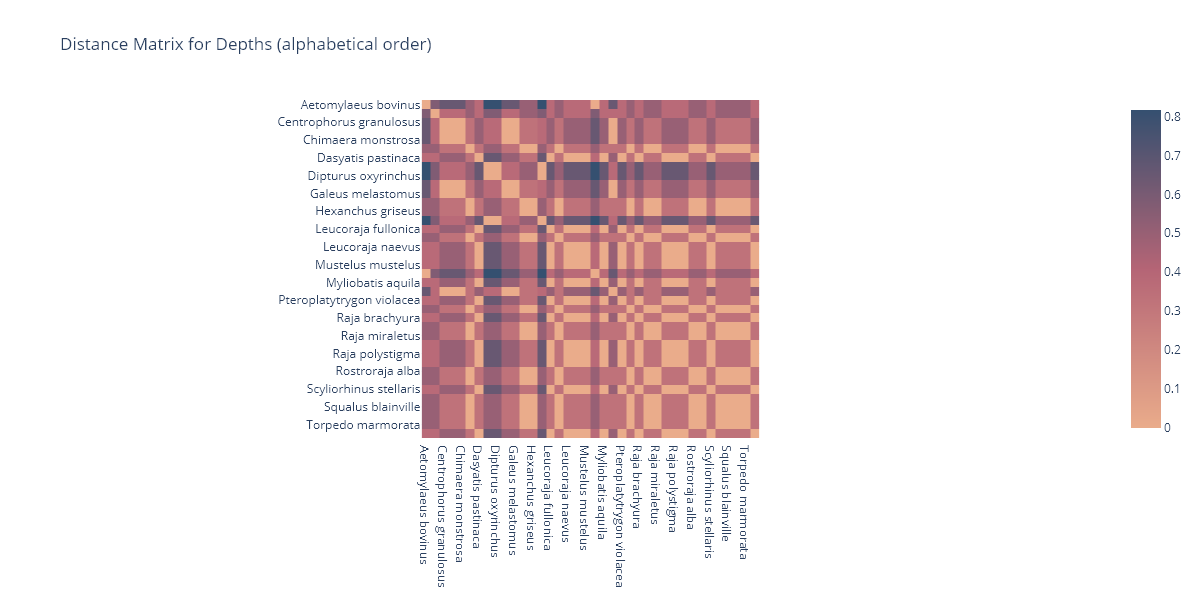

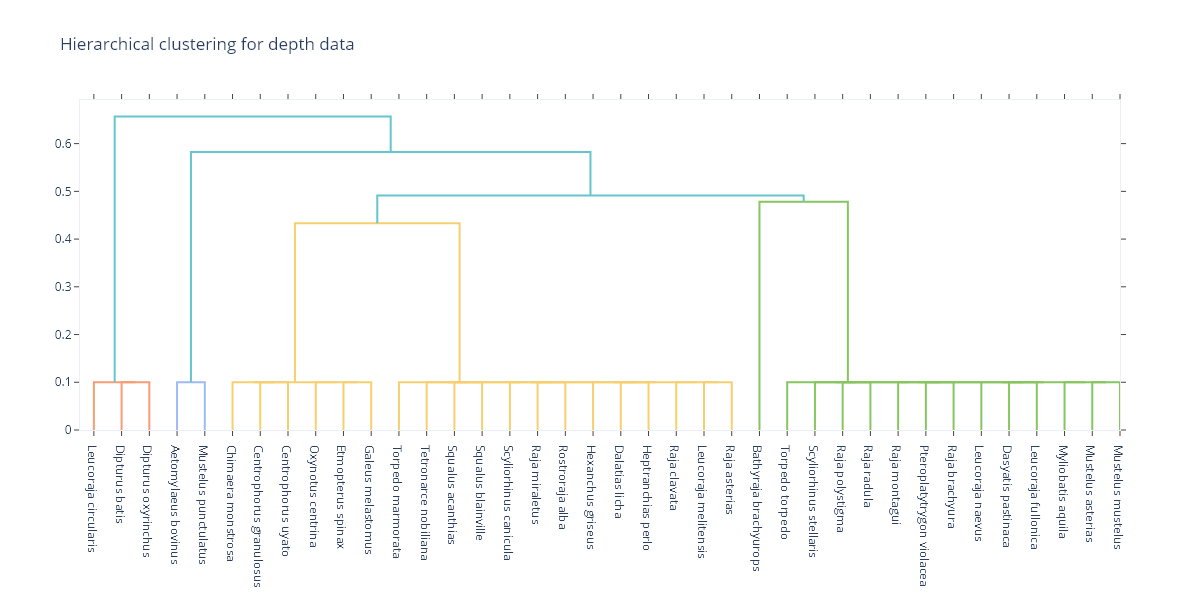

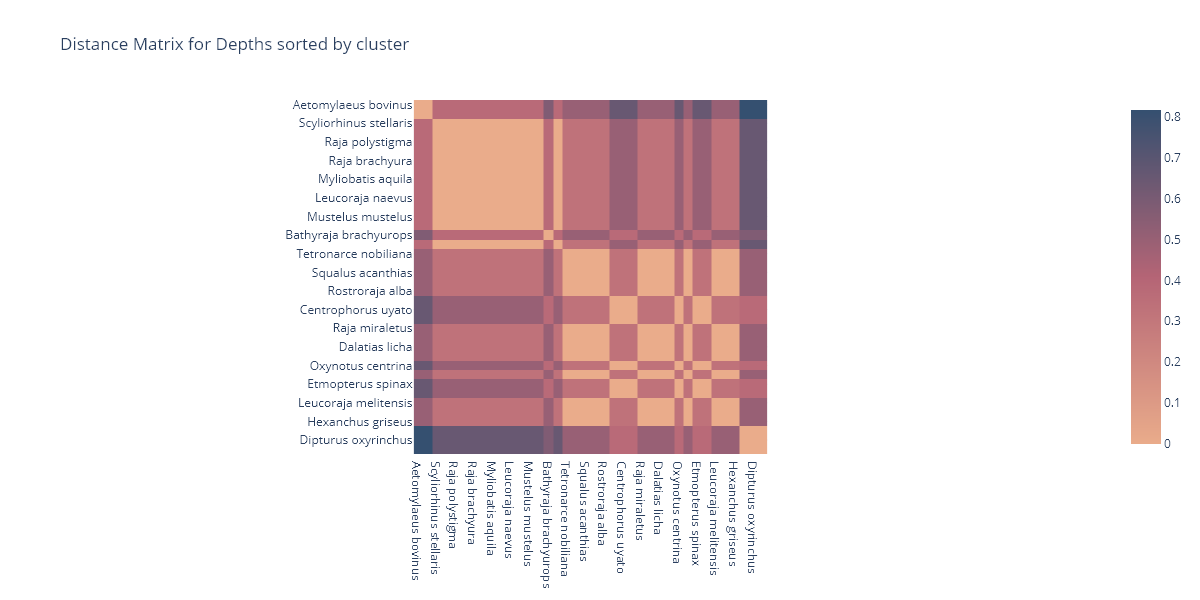

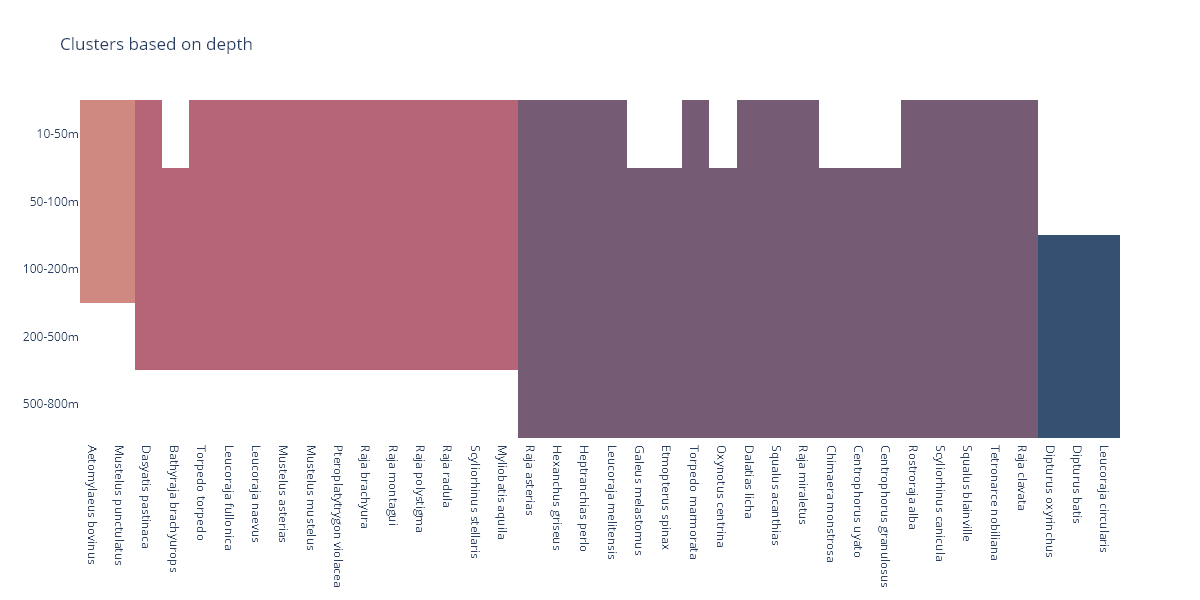

In [307]:
## Calculating coincidence matrix and distance for depths between sharks
depth_coincidence_matrix = calc_coincidence_matrix(depth_df.values)
depth_distance_matrix = calc_metric_distance(depth_coincidence_matrix)

#plot the distance matrix unsorted
fig0 = px.imshow(depth_distance_matrix, title='Distance Matrix for Depths (alphabetical order)', x=depth_df.index, y=depth_df.index, color_continuous_scale=cont_scale)
fig0.update_layout(
    template = 'plotly_white',
    width=1200, height=600
)
fig0.show('png')

## plotting dendrogram and assinging clusters to Depth Cluster column in df
depth_threshold = 0.48
depth_df['Depth Cluster'] = plot_dendro(depth_df, 'average', depth_threshold, 'Hierarchical clustering for depth data', offset=0.1)

#plotting sorted distance matrix
depth_df = depth_df.sort_values('Depth Cluster')
sorted_depth_distance = calc_metric_distance(calc_coincidence_matrix(depth_df.drop(columns='Depth Cluster').values))
fig2 = px.imshow(sorted_depth_distance, title='Distance Matrix for Depths sorted by cluster', x=depth_df.index, y=depth_df.index, color_continuous_scale=cont_scale)
fig2.update_layout(
    template = 'plotly_white',
    width=1200, height=600
)
fig2.show('png')

## plotting the clustered heatmap
z_matrix = calc_z_matrix(depth_df, 'Depth Cluster')
plot_clustered_heatmap(z_matrix, xticks=depth_df.index, yticks=depth_df.drop(columns='Depth Cluster').columns, transpose=True, title='Clusters based on depth', )



___ 
# Diet Clustering
### Data preparation
* In Fishbase the difference between 'Other benthonic invertebrates' and 'benthonic crustacean' is somewhat conventional and strongly affected by the operator who carried out the identification. To avoid possible bias in the following analysis the 2 categories will be merged together in a single category _'benthonic invertebrates'_
* The same ambiguity relies in 'other plank. invertebrates' and 'plank crust.', thus these categories have been merged too
* 'other' and 'other plants' do not appear to be informative

In [308]:
diet_df.drop(columns=['others', 'other plants', 'fish (early stages)'], inplace=True)

newplank = [max(diet_df[['plank. crust.', 'other plank. invertebrates']].loc[i].tolist()) for i in range(len(diet_df))]
diet_df['plank. invertebrates'] = newplank

newbenth = [max(diet_df[['benth. crust.', 'other benth. invertebrates']].loc[i].tolist()) for i in range(len(diet_df))]
diet_df['benth. invertebrates'] = newbenth
diet_df.drop(columns=['benth. crust.', 'other benth. invertebrates', 'insects', 'birds', 'mammals'], inplace=True) #delete uncertain diet item
diet_df = diet_df.set_index('Species')

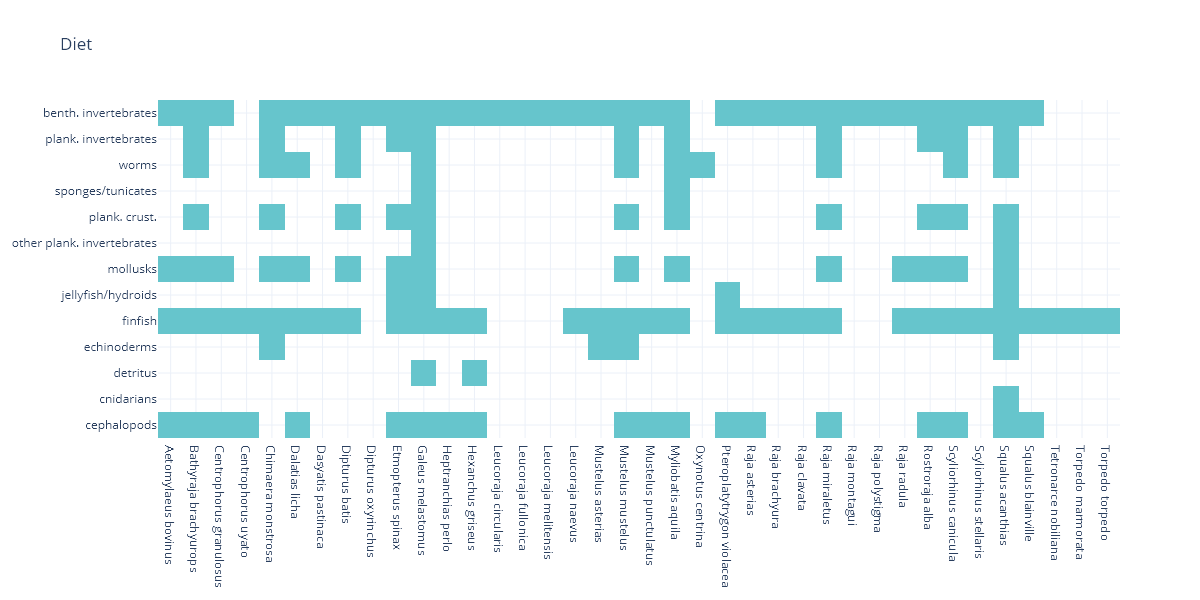

In [309]:
plot_binary_heatmap(diet_df, xticks=diet_df.index.tolist(), yticks=diet_df.columns, title='Diet')

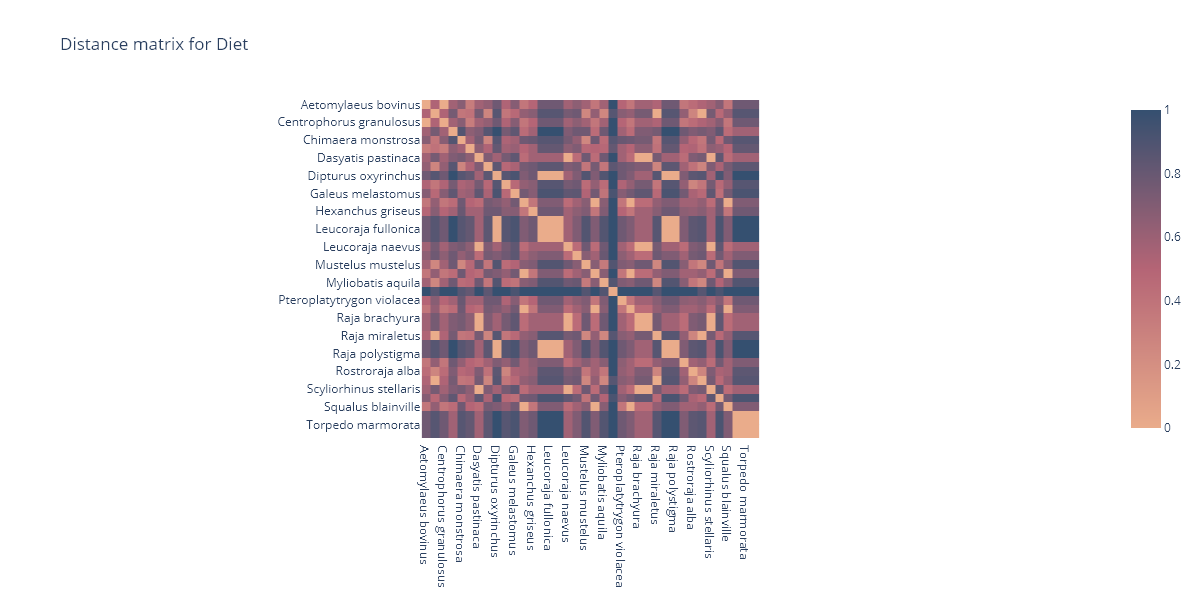

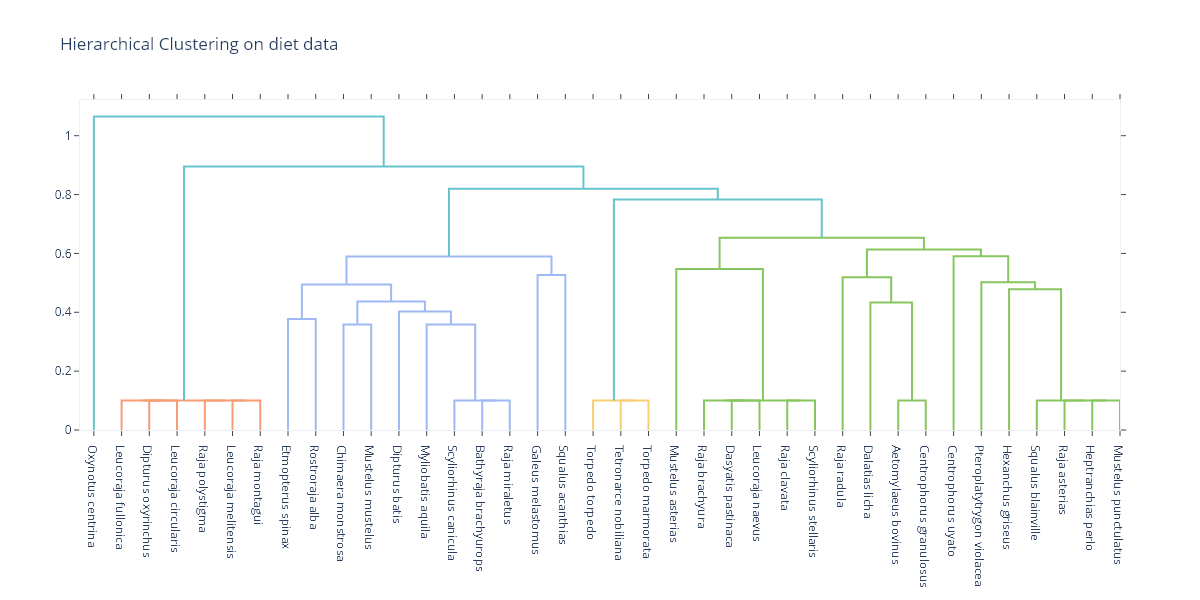

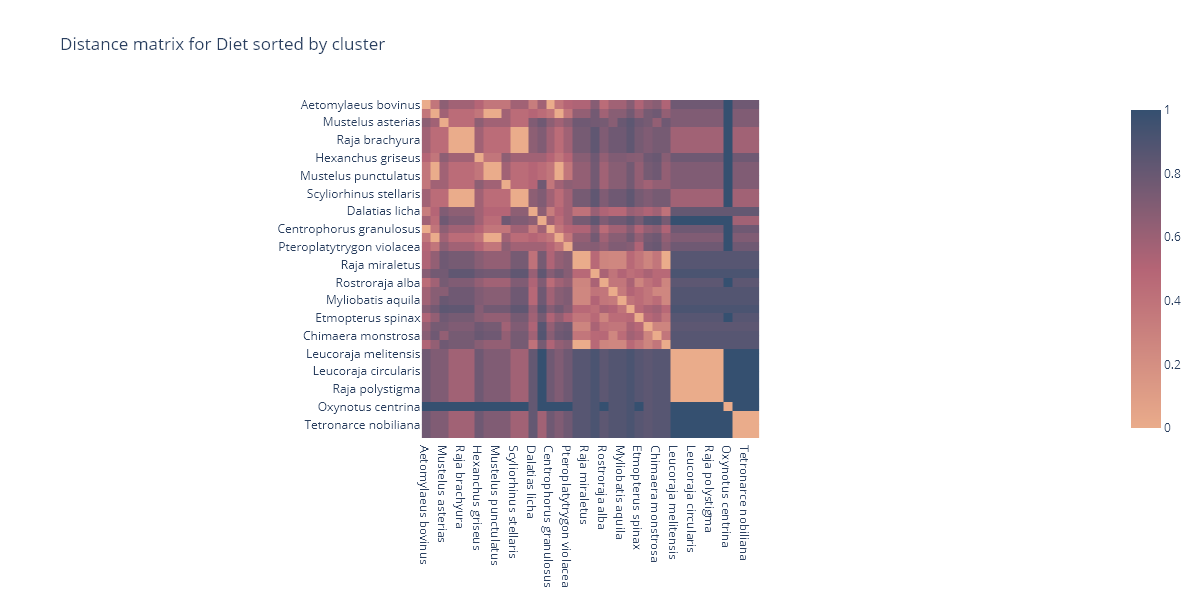

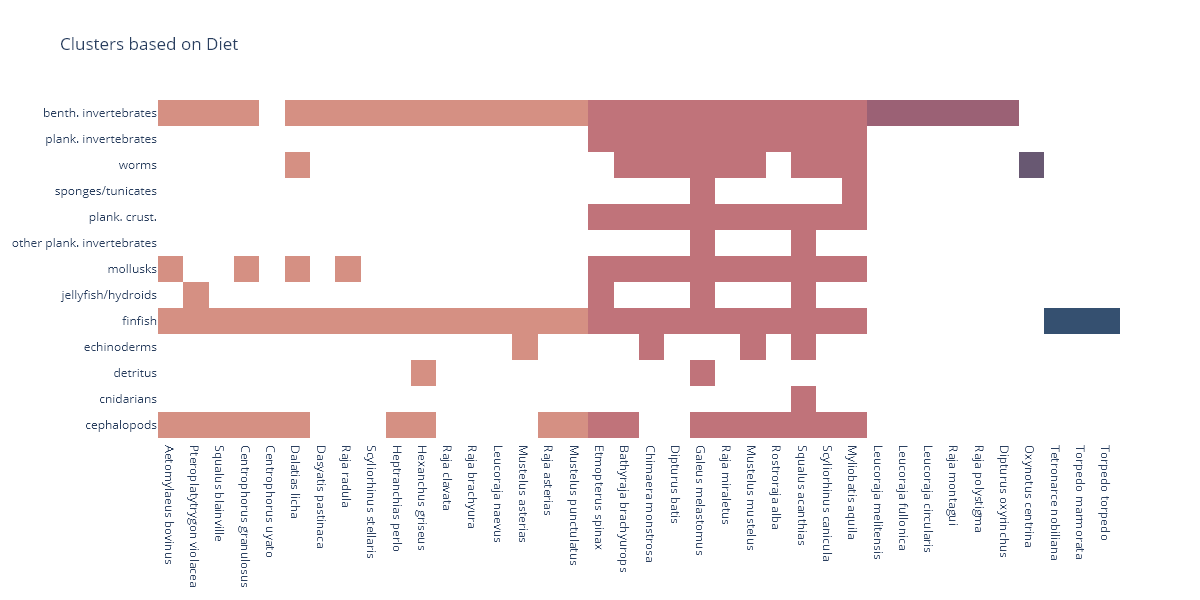

In [310]:
#calculating coincidence index and distance matrix
diet_coincidence_matrix = calc_coincidence_matrix(diet_df.values)
diet_distance_matrix = calc_metric_distance(diet_coincidence_matrix)
fig = px.imshow(diet_distance_matrix, x= diet_df.index, y=diet_df.index, color_continuous_scale=cont_scale, title='Distance matrix for Diet')
fig.update_layout(
    template = 'plotly_white',
    width=1200, height=600
)
fig.show('png')

## plotting dendrogram and assigning clusters names to Diet Cluster column in df
diet_threshold = 0.77
diet_df['Diet Cluster'] = plot_dendro(diet_df, 'average', diet_threshold, 'Hierarchical Clustering on diet data', offset=0.1)

# plotting sorted distance matrix
diet_df.sort_values('Diet Cluster', inplace=True)
sorted_diet_distance = calc_metric_distance(calc_coincidence_matrix(diet_df.drop(columns='Diet Cluster').values))
fig = px.imshow(sorted_diet_distance, x=diet_df.index, y=diet_df.index, title='Distance matrix for Diet sorted by cluster', color_continuous_scale=cont_scale)
fig.update_layout(
    template = 'plotly_white',
    width=1200, height=600
)
fig.show('png')

#Plotting clustered heatmap
z_matrix = calc_z_matrix(diet_df, 'Diet Cluster')
plot_clustered_heatmap(z_matrix, transpose=True, xticks=diet_df.index, yticks=z_matrix.columns, title='Clusters based on Diet',)

# Cluster Analysis <a class="anchor" id='clust_an'></a>
## Clusters Indexes Comparison <a class="anchor" id='clus_ind'></a>

### Rand Index
**Definition**  
Given a set of $n$ elements $S = \{o_1, \ldots, o_n\}$ and two partitions of $S$ to compare, $X = \{X_1, \ldots, X_r\}$, a partition of $S$ into $r$ subsets, and $Y = \{Y_1, \ldots, Y_s\}$, a partition of $S$ into $s$ subsets, define the following:
* $a$, the number of pairs of elements in $S$ that are in the *same* subset in $X$ and in the *same* subset in $Y$
* $b$, the number of pairs of elements in $S$ that are in *different* subsets in $X$ and in *different* subsets in $Y$
* $c$, the number of pairs of elements in $S$ that are in the *same* subset in $X$ and in *different* subsets in $Y$
* $d$, the number of pairs of elements in $S$ that are in *different* subsets in $X$ and in the *same* subset in $Y$  

The Rand index, $R$, is:
$$ R = \frac{a+b}{a+b+c+d} = \frac{a+b}{{n \choose 2 }}$$
Intuitively,  $a + b$ can be considered as the number of agreements between $X$ and $Y$ and $c + d$ as the number of disagreements between $X$ and $Y$.
Since the denominator is the total number of pairs, the Rand index represents the 'frequency of occurrence' of agreements over the total pairs, or the probability that $X$ and $Y$ will agree on a randomly chosen pair.
The Rand index has a value between 0 and 1, with 0 indicating that the two data clusterings do not agree on any pair of points and 1 indicating that the data clusterings are exactly the same.
#### Adjusted Rand Index - ARI
The adjusted Rand index is the corrected-for-chance version of the Rand index. Such a correction for chance establishes a baseline by using the expected similarity of all pair-wise comparisons between clusterings specified by a random model.  
Though the Rand Index may only yield a value between 0 and +1, the adjusted Rand index can yield negative values if the index is less than the expected index.
### Jaccard Index
The Jaccard index, also known as the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets.  
The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets: $$ J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$
Applying the same notation used for Coincidence index, it can be formulated as
$$ J = \frac{a}{a+b+c} $$
### Mutual Information
In probability theory and information theory, the mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" (in units such as shannons (bits), nats or hartleys) obtained about one random variable by observing the other random variable. The concept of mutual information is intimately linked to that of entropy of a random variable, a fundamental notion in information theory that quantifies the expected "amount of information" held in a random variable. It corresponds to the expected value of Punctual Mutual Information 
$$ PMI = \log{ \frac{\frac{a}{\sqrt{(a+b)(a+c)}}}{\sqrt{\frac{a+b}{n} \frac{a+c}{n}}}} $$
<sub> [StackExchange](https://stats.stackexchange.com/questions/256684/jaccard-similarity-coefficient-vs-point-wise-mutual-information-coefficient) </sub>

#### Adjusted Mutual Information - AMI
The adjusted mutual information or AMI subtracts the expectation value of the MI, so that the AMI is zero when two different distributions are random, and one when two distributions are identical.

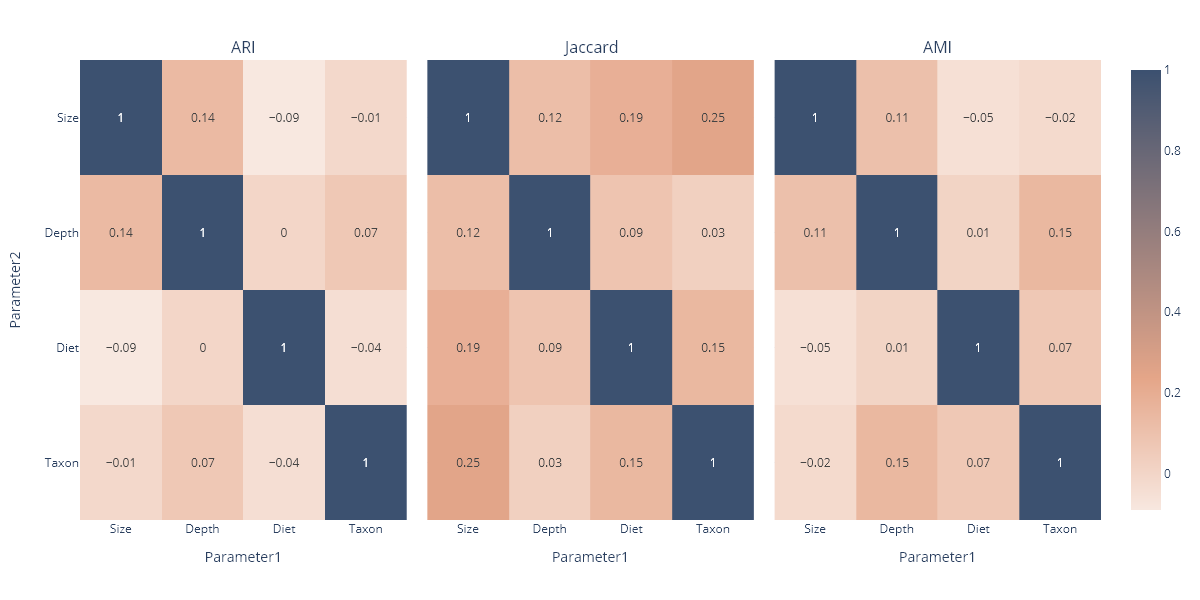

In [311]:
size_cluster = size_df.sort_values('Species', ignore_index=True)['Size Cluster'].astype(str)
depth_cluster = depth_df.sort_values('Species',ignore_index=True)['Depth Cluster'].astype(str)
diet_cluster = diet_df.sort_values('Species',ignore_index=True)['Diet Cluster'].astype(str)
taxon_cluster = size_df.sort_values('Species',ignore_index=True)['Taxonomic Unit'].astype(str)

## creating a df with all the cluster names for different descriptors
cluster_df = pd.DataFrame({
    'Species': size_df.sort_values('Species', ignore_index=True)['Species'],
    'Size Cluster': size_cluster,
    'Depth Cluster': depth_cluster,
    'Diet Cluster': diet_cluster,
    'Taxon Cluster': taxon_cluster,
})

## uniforming taxon clusters names with the others
replacements = ['C{}'.format(i) for i in range(1,len(cluster_df['Taxon Cluster'].unique())+1)]
cluster_df['Taxon Cluster'] = cluster_df['Taxon Cluster'].replace(cluster_df['Taxon Cluster'].unique(), replacements)
cluster_mtx = [cluster_df['Size Cluster'], cluster_df['Depth Cluster'], cluster_df['Diet Cluster'], cluster_df['Taxon Cluster']] 
nn = len(cluster_mtx)

## function that plot cluster analysis indexes for each couple of descriptors
def calc_clust_analysis_index(cluster_matrix):
    light_scale = [
        [0, 'rgb(248, 232, 224)'],
        [0.3, 'rgb(229, 166, 137)'],
        [1, 'rgb(60, 81, 112)']
    ]

    ari_mtx = [[i for i in range(nn)] for i in range(nn)]
    jaccard_mtx = [[i for i in range(nn)] for i in range(nn)]
    ami_mtx = [[i for i in range(nn)] for i in range(nn)]
    for i in range(len(cluster_matrix)):
        for j in range(len(cluster_matrix)):
            ari_mtx[i][j] = ari(cluster_matrix[i],cluster_matrix[j])
            jaccard_mtx[i][j] = jaccard_score(cluster_matrix[i], cluster_matrix[j], average='micro')
            ami_mtx[i][j] = ami(cluster_matrix[i], cluster_matrix[j])

    mtx_plot_df = pd.DataFrame(
        {
            'Correlation Metrics': ['ARI', 'Jaccard', 'AMI'],
            'Index Matrix': [ari_mtx, jaccard_mtx, ami_mtx],
        }
    )
    data_array = [i for i in mtx_plot_df['Index Matrix']]
    data_xarray = xr.DataArray(
        data=data_array,
        dims=['Metrics', 'Parameter2', 'Parameter1'],
        coords={'Metrics': [1,2,3],
                'Parameter1': ['Size', 'Depth', 'Diet', 'Taxon'],
                'Parameter2': ['Size', 'Depth', 'Diet', 'Taxon']
                }
    )
    fig = px.imshow(np.around(data_xarray, 2), facet_col='Metrics', x=data_xarray['Parameter1'].data, y=data_xarray['Parameter1'].data, color_continuous_scale=light_scale, zmax=1, text_auto=True)
    new_titles = ['ARI', 'Jaccard', 'AMI']
    for k in range(len(new_titles)):
        fig.layout.annotations[k].update(text = new_titles[k], font_size=16)
    fig.update_layout(
        template = 'plotly_white',
        width=1200, height=600
    )
    fig.show('png')
    
calc_clust_analysis_index(cluster_mtx)

___
## Markov Chain Monte Carlo
### Labels Optimization Algorithm 
#### Goal
The goal is to maximize the number of times each species is included in a cluster wiht the same cluster names.
#### Why it is necessary
When hierarchical clustering algorythms assign a cluster index there is no particular order in which they do that. Two very similar species A and B might always co-occur in the same cluster but the names given to each cluster might be different (like 'Cluster1', 'ClustA' or 'Cx' depending on the method).  
**Jaccard index** depends on the names of the clusters while AMI and ARI only count co-occurrence.
It would be possible to modify Jaccard index in a similar way of the other 'Adjusted' indexes so that it would count co-occurrence using a contingency table. In this case I chose to develop a heuristic algorithm because I wanted to try this type of approach. 


#### Algorithm Explaination
The dataframe include one column for each object and one row for each clustering method.  
The aim is to maximixe the number of times one columns contains the same value.  
An appropriate Scoring System has been defined in order to obtain maximum values when in each column there is only one value and minimum when all the values are different.   

0) Duplicate the starting df --> temp_df    || This is necessary to compare the 2 dfs
1) Choose a random column of the temp_df
2) Permute labels in that column 
3) Calculate the partial-score along all the columns
3) Calc Match score on the entire state as sum of partial-scores for each row both for original df (Mscore) and for temp_df (Mscore')
4) If Mscore' > Mscore --> move in that direction but if Mscore' < Mscore there is a certain probability to move in that direction too.

#### Metropolis Choice
In random walk algorithms it is always important to check for local maxima as they might prevent to  obtain the best possible solution.  
A greedy algorythm always move towards higher values, thus it is very susceptible to local maxima.  
Metropolis Algorithm let the random walk follow the score gradient while also inserting a certain probability move in a direction with lower score with a certain probability, this let the walker visit a broader space.

In [312]:
def permute_column(df):   #permute the values in one random column of the dataframe
    df = df.copy(deep=True)
    a = np.random.randint(0, len(df.columns))
    column_name = df.iloc[:,a].name
    rep1, rep2 = random.sample(df.iloc[:,a].unique().tolist(), k=2)
    new_df = df.copy(deep=True)
    new_column = df.iloc[:,a].replace([rep1, rep2], [rep2, rep1])
    new_df[column_name] = new_column
    return new_df
    
def calc_partial(column): # calculate the score for ech column (aka species)
    vec = column.value_counts().tolist()
    partial_score=0
    for i in vec:
    ## Scoring system defined this way: max if the species is always in the same cluster, minimum if all clusters are different
        partial_score+=i**2  
    return partial_score

def calc_Mscore(df): #after each iteration this function sums all the scores to obtain a score of the entire state
    mscore = 0
    for i in range(len(df)):
        mscore += calc_partial(df.iloc[i])
    return mscore

def greedy_replace(new_mscore, mscore, new_df, df):  ## Greedy algorithm always follow the gradient and never visit low score spaces
    if new_mscore >= mscore:
        return new_df, new_mscore
    else:
        return df, mscore

def metropolis_replace(new_mscore, mscore, new_df, df, beta):  
    #always moves to higher scores, but can also visit lower score space with a certain probability
    if new_mscore >= mscore:
        return new_df, new_mscore
    else:
        if np.random.rand() < np.exp(-beta * (mscore-new_mscore)):   #definition of the probability function
            return new_df, new_mscore
        else:
            return df, mscore

def group_clusters(origin_df, beta = 1, label_choice = None):
    if label_choice == None:
        label_choice = 'greedy'    
    new_df = permute_column(origin_df)
    mscore = calc_Mscore(origin_df)
    new_mscore = calc_Mscore(new_df)
    if label_choice == 'greedy':
        return greedy_replace(new_mscore, mscore, new_df, origin_df)
    else:
        return metropolis_replace(new_mscore, mscore, new_df, origin_df, beta)


def cold_chain(origin_df):  
    #this 'chain' represent a totally random walker
    #it is used to assess wheter a local maximum has been reached but it is not the global maximum
    for i in range(10):                 #permute the values of ten random columns (with resampling)
        origin_df=permute_column(origin_df)     #the original df is replaced with a randomly permuted one
    new_mscore = calc_Mscore(origin_df)
    return origin_df, new_mscore

def watch_scores(score_list=[], names_list=[]): #plot the score of the state at each iteration
    fig = go.Figure()                           #it is possible to input different scores as a list to compare them
    for idx, vec in enumerate(score_list):
        fig.add_trace(go.Scatter(y=vec, name=names_list[idx], marker_color=px.colors.qualitative.Pastel[idx]))
        fig.update_xaxes(title='Number of Iterations')
        fig.update_layout(template='plotly_white', title='System Score at each iteration')
    fig.update_layout(
        template = 'plotly_white',
        width=1200, height=600
    )
    fig.show('png')

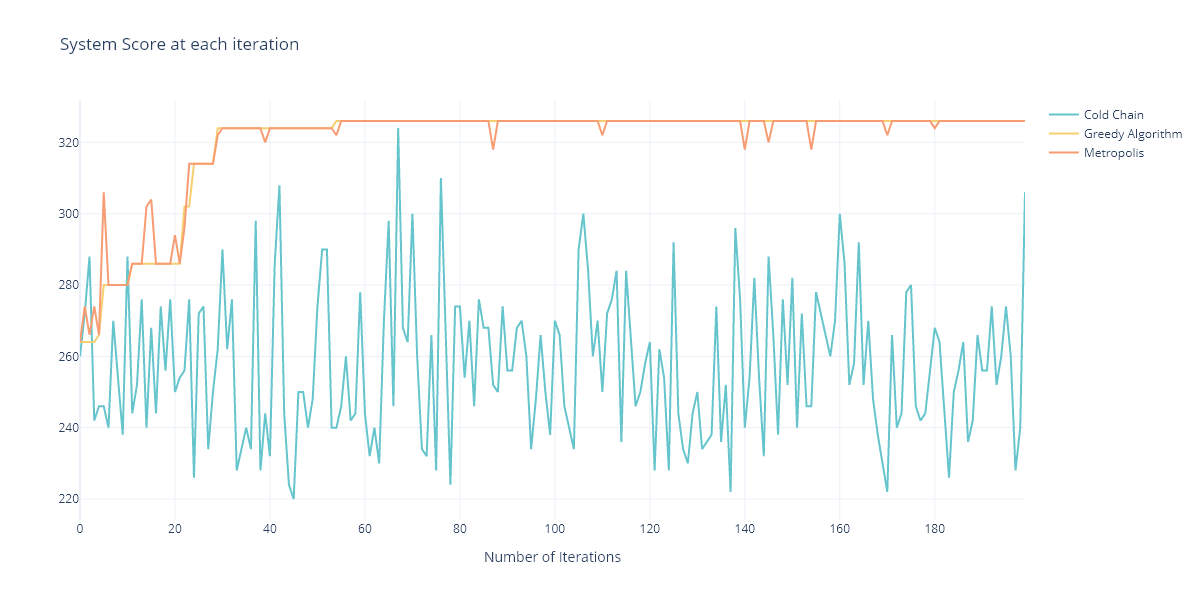

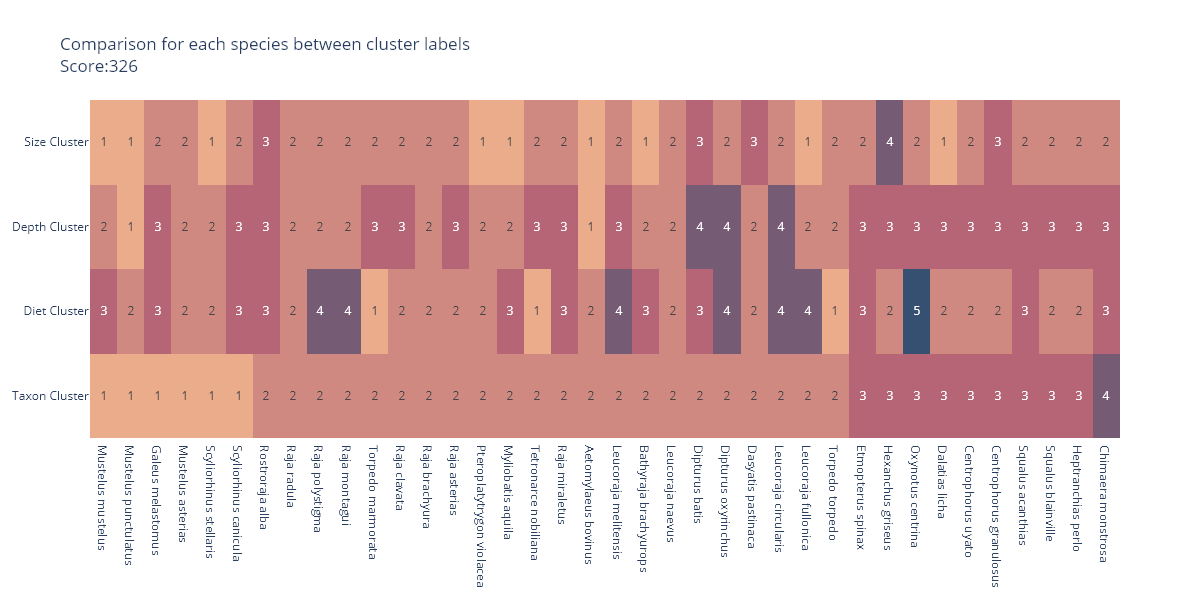

In [313]:
df = cluster_df.copy()
df = df.sort_values('Species').set_index('Species')
mk_df = df.copy()   #df for the cold chain comparison
mscore_vec = []     #vec containing scores obtained by greedy algorithm
mscore_vec1 = []    #vec with scores obtained from metropolis algorithm
mkscore_vec = []    #vec with cold chain scores
iterations = 200

for i in range(iterations):
    df, mscore = group_clusters(df, label_choice='greedy')
    df1, mscore1 = group_clusters(df, beta=0.4, label_choice='metro')
    mk_df, mkscore = cold_chain(mk_df)
    mscore_vec.append(mscore)
    mscore_vec1.append(mscore1)
    mkscore_vec.append(mkscore)
watch_scores([mkscore_vec, mscore_vec, mscore_vec1], ['Cold Chain','Greedy Algorithm','Metropolis'])


labels = pd.unique(np.array([df.iloc[i].tolist() for i in range(len(df))]).flatten()).tolist()
new_labels = [i for i in range(1, len(labels)+1)]
comparison_df = df1.replace(labels, new_labels).transpose()
comparison_df.columns = cluster_df['Species'].tolist()

comparison_df.sort_values('Taxon Cluster', axis=1, inplace=True) #set the taxon as reference for sorting
#plot of the heatmap
#each species has a different color accoridng to the cluster value it has assigned
fig = px.imshow(comparison_df, x=comparison_df.columns, y=comparison_df.index,
    title='Comparison for each species between cluster labels <br>Score:{}'.format(mscore),
    color_continuous_scale=cont_scale, aspect='auto', text_auto=True)
fig.update_layout(
    template = 'plotly_white',
    width=1200, height=600
)
fig.layout.coloraxis.showscale = False
fig.show('png')

Once the algorithm has optimized the labels names, we should see an increase for Jaccard index values, while still mantaining all ARI and AMI values constant.  
This happens because both indexes are 'Adjusted' and do not depend on the labels name but only on the co-occurrence of objects in the same cluster. 

Below there is a plot showing the effect of the MCMC algorithm. As expected Jaccard index increased its values while the other indexes remained constant.

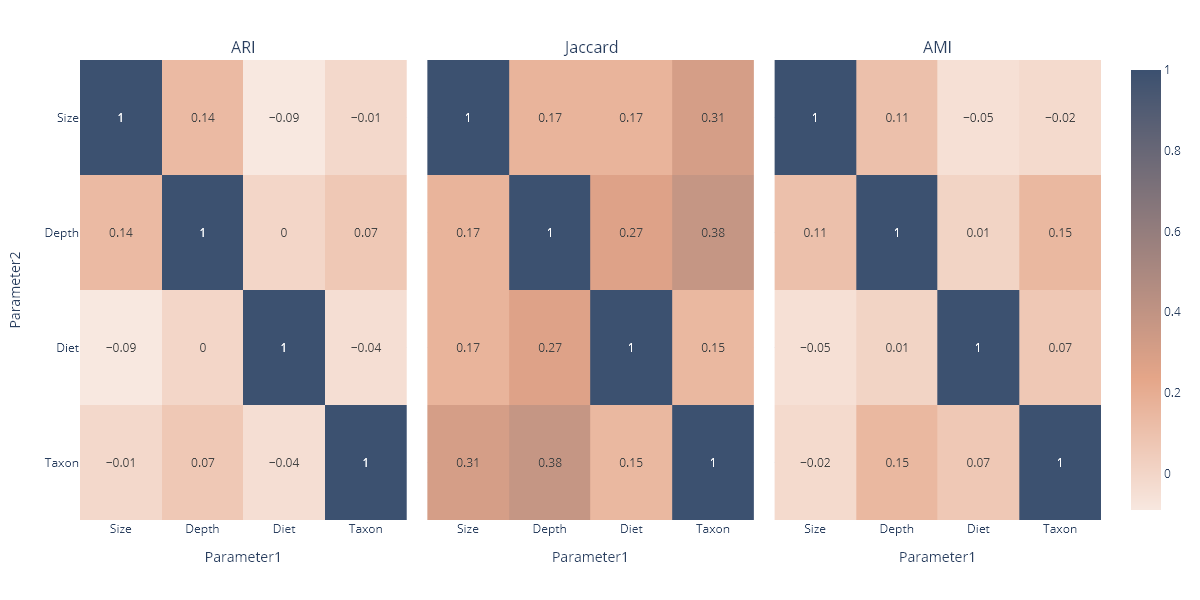

In [314]:
calc_clust_analysis_index(comparison_df.values)

Since all clusters appear to be very different (low values for all indexes) there is no reason to choose one method over one other just from this analysis. 
One could also evaluate the confidence of each clustering using at least 3 different approaches:

* Silhouette Scores
* Cophenetic Correlation Index
* Bootstrap Probability 

In the lack of further knowledge the choice of which clustering is more appropriate can be guided by these 3 methods that assess the robustness of each clustering.
This type of analysis has not been applied in this case because this project has been canceled at this point, but it has been included in the final version of my thesis work.